In [282]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [283]:
data = pd.read_csv("2016_Building_Energy_Benchmarking_prediction.csv")
data

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,PrimaryPropertyType_Distribution Center,...,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,47.61220,-122.33799,1927,1.0,12,88434,60.0,7.226362e+06,249.98,0,...,1,0,0,0,0,0,0,0,0,0
1,47.61317,-122.33393,1996,1.0,11,103566,61.0,8.387933e+06,295.86,0,...,1,0,0,0,0,0,0,0,0,0
2,47.61393,-122.33810,1969,1.0,41,956110,43.0,7.258702e+07,2089.28,0,...,1,0,0,0,0,0,0,0,0,0
3,47.61412,-122.33664,1926,1.0,10,61320,56.0,6.794584e+06,286.43,0,...,1,0,0,0,0,0,0,0,0,0
4,47.61375,-122.34047,1980,1.0,18,175580,75.0,1.417261e+07,505.01,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,47.53161,-122.29944,1929,1.0,2,24990,9.0,4.420650e+06,134.80,0,...,0,0,1,0,0,0,0,0,0,0
1074,47.58831,-122.30650,2015,1.0,3,45000,77.0,1.325973e+06,9.24,0,...,0,0,1,0,0,0,0,0,0,0
1075,47.63572,-122.37525,1952,1.0,1,13661,75.0,5.026677e+05,3.50,0,...,0,0,0,0,1,0,0,0,0,0
1076,47.56440,-122.27813,1960,1.0,1,15398,93.0,3.878100e+05,7.79,0,...,0,0,0,0,0,0,0,0,1,0


In [284]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 37 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Latitude                                         1078 non-null   float64
 1   Longitude                                        1078 non-null   float64
 2   YearBuilt                                        1078 non-null   int64  
 3   NumberofBuildings                                1078 non-null   float64
 4   NumberofFloors                                   1078 non-null   int64  
 5   PropertyGFATotal                                 1078 non-null   int64  
 6   ENERGYSTARScore                                  1078 non-null   float64
 7   SiteEnergyUse(kBtu)                              1078 non-null   float64
 8   TotalGHGEmissions                                1078 non-null   float64
 9   PrimaryPropertyType_Distributi

### Variables cibles pertinentes
Dans cette cellule, nous allons identifier les variables cibles pertinentes :
- Consommation totale d’énergie
- Consommation de CO2.

In [285]:
# Identifying target and features
co2_target = 'TotalGHGEmissions'
energy_target = 'SiteEnergyUse(kBtu)'
targets = [co2_target, energy_target]
data = data.dropna(subset=targets)


###  Vérification de data leakage
Dans cette cellule, nous vérifierons qu'il n'y a pas de problème de fuite de données (data leakage).

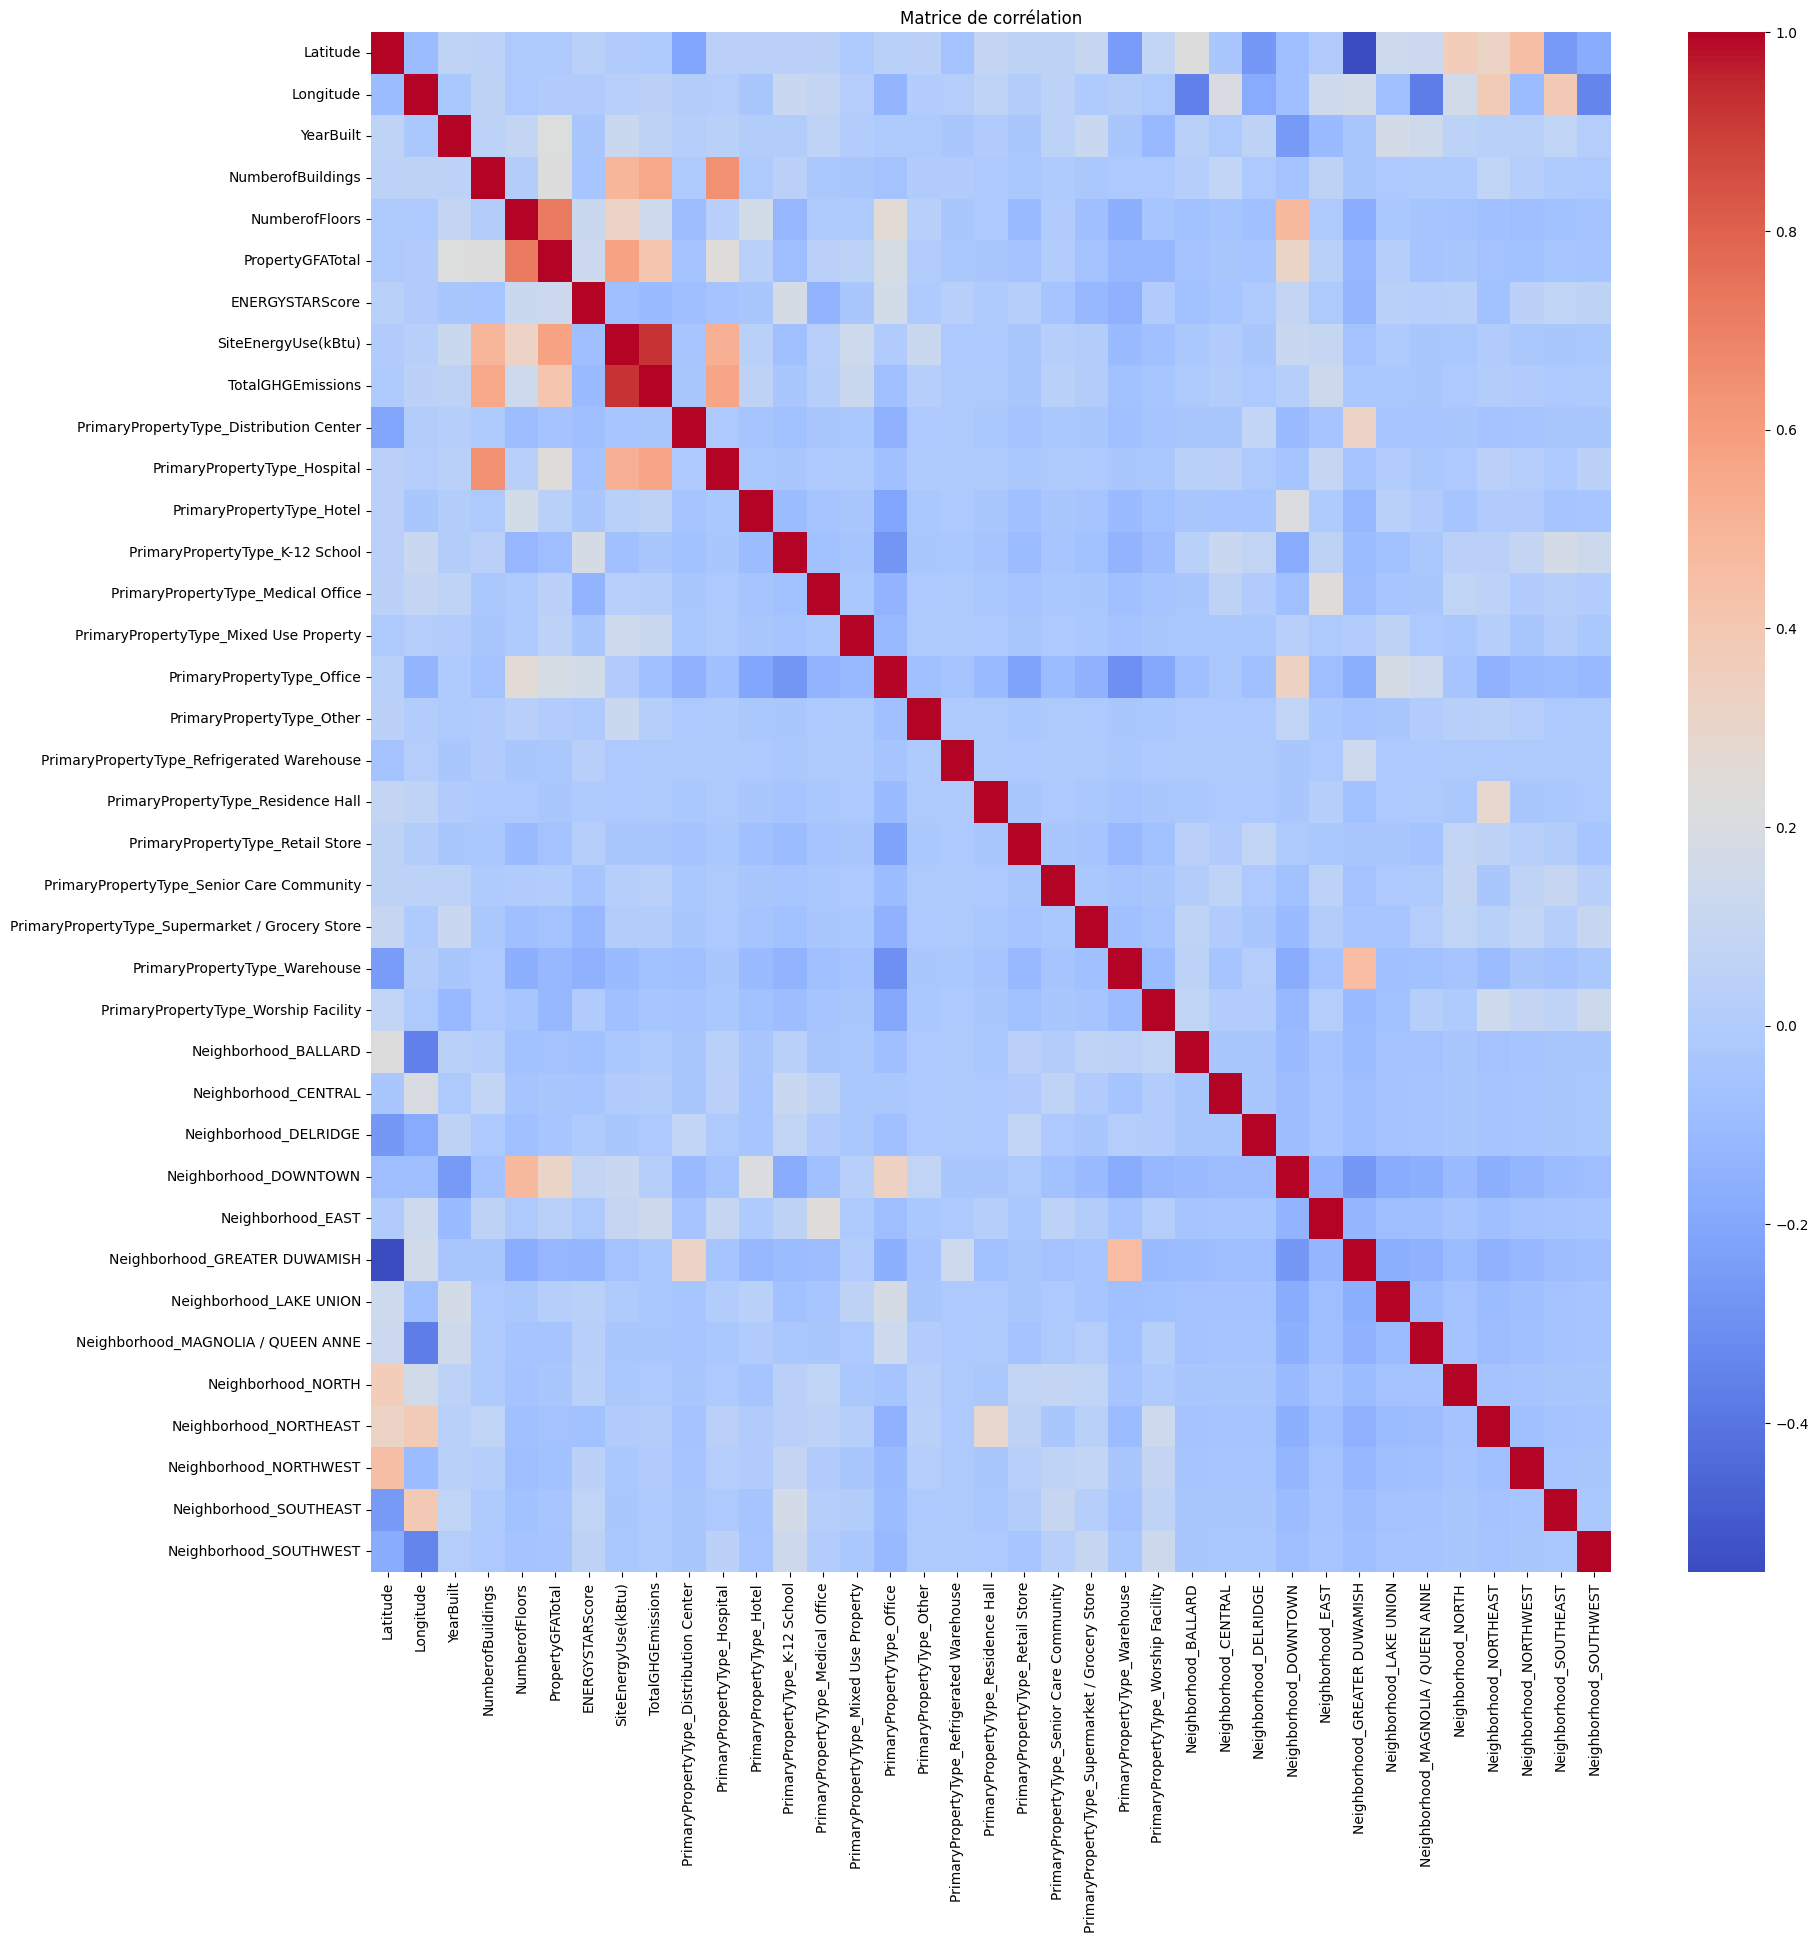

In [286]:
# Matrice de corrélation
correlation_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

In [287]:
features = [col for col in data.columns if col not in targets]
features_no_es = [col for col in data.columns if col not in targets and col != 'ENERGYSTARScore']

numerical_features = data[features].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = data[features].select_dtypes(include=['object']).columns.tolist()

# Preprocessing for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


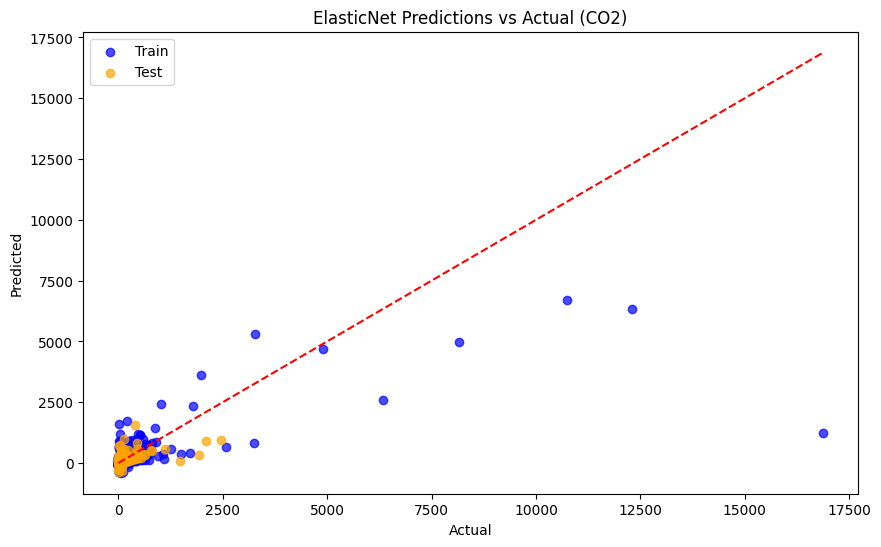

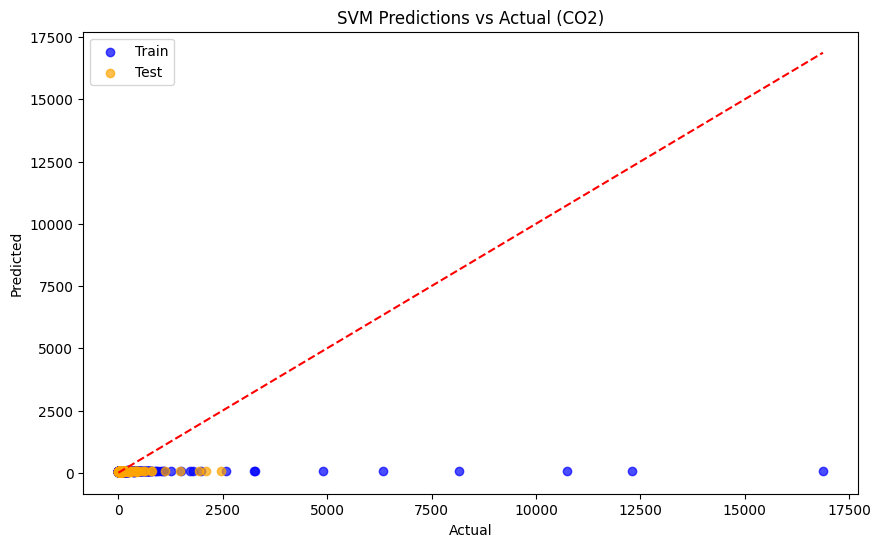

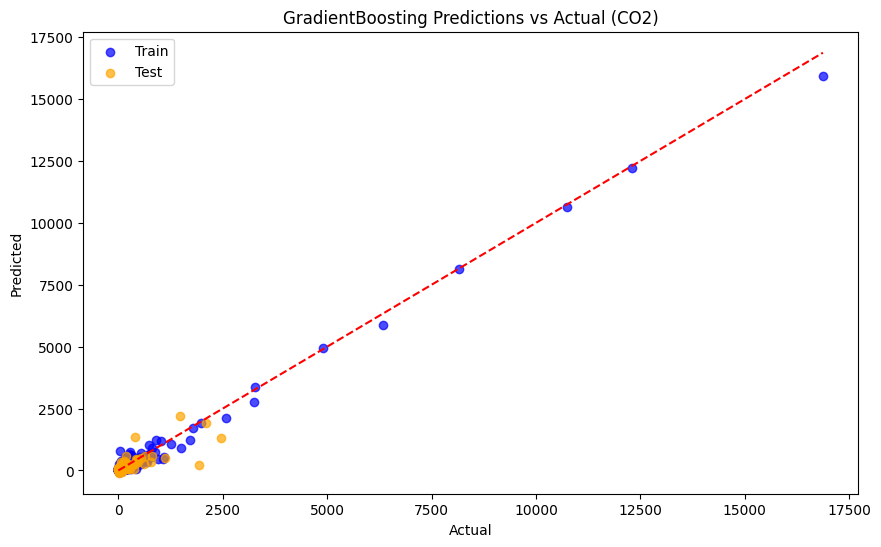

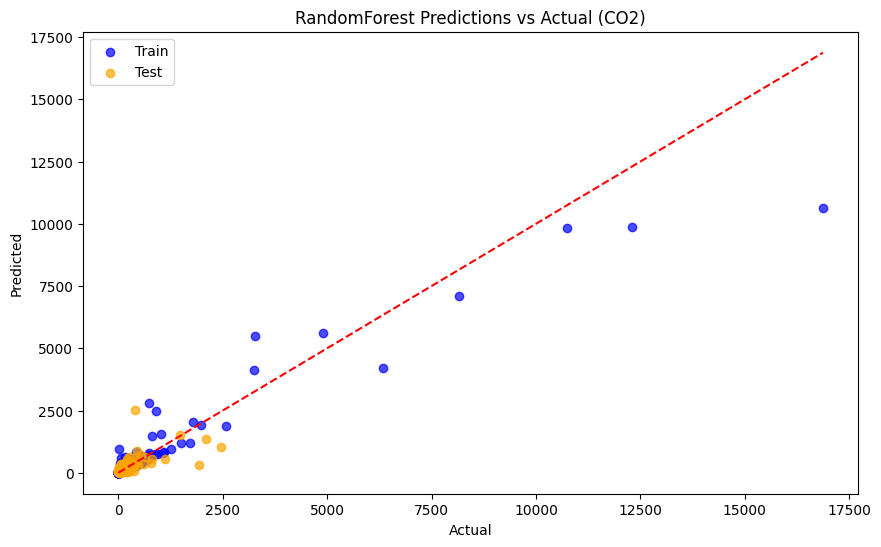

                      Train MSE      Test MSE  Train R2   Test R2   Train MAE  \
ElasticNet        433247.604002  70613.164880  0.482138  0.205876  164.707480   
SVM               853795.240239  92128.981212 -0.020543 -0.036093  171.154420   
GradientBoosting   10398.366834  34967.884607  0.987571  0.606747   56.383886   
RandomForest       80354.914211  54677.611563  0.903952  0.385089   53.817078   

                    Test MAE  
ElasticNet        138.849113  
SVM               107.772735  
GradientBoosting   76.813720  
RandomForest       85.806429  


In [288]:
# Define models
models = {
    'ElasticNet': ElasticNet(random_state=42),
    'SVM': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

# Splitting data into train and test sets
X = data[features]
y_co2 = data[co2_target]

X_train, X_test, y_train_co2, y_test_co2 = train_test_split(X, y_co2, test_size=0.2, random_state=42)

# Evaluate each model and store results
results = {}
all_predictions = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Fit and predict for CO2
    pipeline.fit(X_train, y_train_co2)
    co2_train_pred = pipeline.predict(X_train)
    co2_test_pred = pipeline.predict(X_test)

    mse_train = mean_squared_error(y_train_co2, co2_train_pred)
    r2_train = r2_score(y_train_co2, co2_train_pred)
    mae_train = mean_absolute_error(y_train_co2, co2_train_pred)

    mse_test = mean_squared_error(y_test_co2, co2_test_pred)
    r2_test = r2_score(y_test_co2, co2_test_pred)
    mae_test = mean_absolute_error(y_test_co2, co2_test_pred)

    results[name] = {
        'Train MSE': mse_train,
        'Test MSE': mse_test,
        'Train R2': r2_train,
        'Test R2': r2_test,
        'Train MAE': mae_train,
        'Test MAE': mae_test
    }
    all_predictions[name] = co2_test_pred

    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train_co2, co2_train_pred, alpha=0.7, label='Train', color='blue')
    plt.scatter(y_test_co2, co2_test_pred, alpha=0.7, label='Test', color='orange')
    plt.plot([min(y_test_co2.min(), y_train_co2.min()), max(y_test_co2.max(), y_train_co2.max())], 
             [min(y_test_co2.min(), y_train_co2.min()), max(y_test_co2.max(), y_train_co2.max())], 
             color='red', linestyle='--')
    plt.title(f'{name} Predictions vs Actual (CO2)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

In [289]:
results_df

,Train MSE,Test MSE,Train R2,Test R2,Train MAE,Test MAE
ElasticNet,433247.604002,70613.164880,0.482138,0.205876,164.707480,138.849113
SVM,853795.240239,92128.981212,-0.020543,-0.036093,171.154420,107.772735
GradientBoosting,10398.366834,34967.884607,0.987571,0.606747,56.383886,76.813720
RandomForest,80354.914211,54677.611563,0.903952,0.385089,53.817078,85.806429


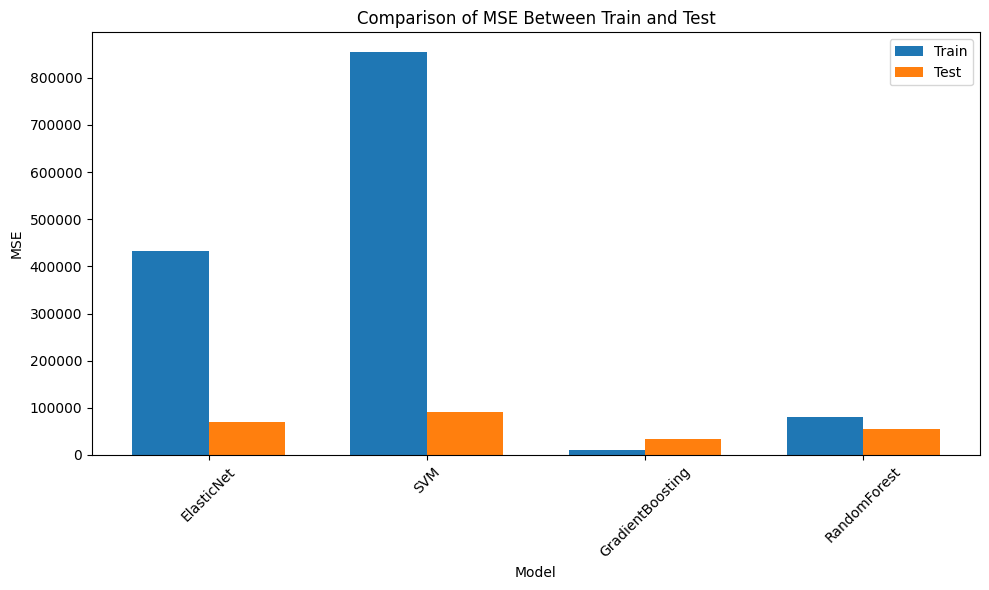

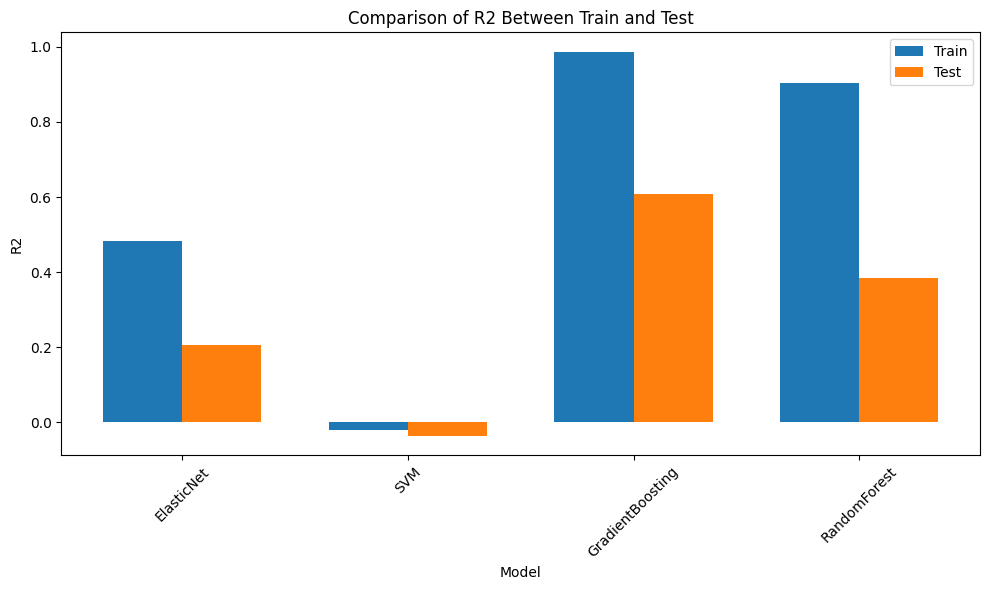

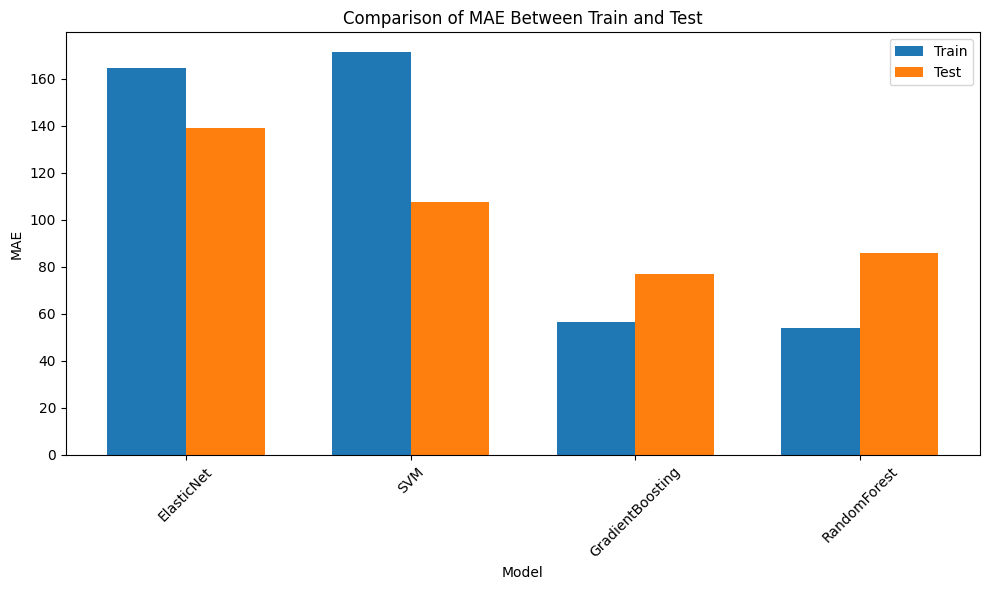

In [290]:
# Plot histograms for comparison of performance metrics between Train and Test
metrics = ['MSE', 'R2', 'MAE']

for metric in metrics:
    train_values = [results[model][f'Train {metric}'] for model in models.keys()]
    test_values = [results[model][f'Test {metric}'] for model in models.keys()]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, train_values, width, label='Train')
    plt.bar(x + width/2, test_values, width, label='Test')

    plt.title(f'Comparison of {metric} Between Train and Test')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(x, models.keys(), rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [291]:


# Définir l'espace des hyperparamètres
param_distributions = {
    'model__n_estimators': randint(1, 500),
    'model__learning_rate': uniform(0.01, 0.5),
    'model__max_depth': randint(1, 20),
    'model__min_samples_split': randint(1, 20),
    'model__min_samples_leaf': randint(1, 5),
    'model__subsample': uniform(0.6, 0.4),
    'model__max_features': [1.0, 'sqrt', 'log2', None] 
}

# Définir le pipeline pour le Gradient Boosting
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', GradientBoostingRegressor(random_state=42))])

# Configurer RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,  
    scoring='r2',  
    random_state=42,
    n_jobs=-1,  
    verbose=2
)

# Lancer la recherche des meilleurs hyperparamètres
random_search.fit(X_train, y_train_co2)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés :", random_search.best_params_)
print("Meilleur score R2 :", random_search.best_score_)

# Tester avec le modèle optimal sur les données de test
best_model = random_search.best_estimator_
co2_pred_best = best_model.predict(X_test)

# Calculer les métriques finales
final_mse = mean_squared_error(y_test_co2, co2_pred_best)
final_r2 = r2_score(y_test_co2, co2_pred_best)
final_mae = mean_absolute_error(y_test_co2, co2_pred_best)

print("Performance du meilleur modèle sur les données de test :")
print(f"MSE : {final_mse}")
print(f"R2 : {final_r2}")
print(f"MAE : {final_mae}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END model__learning_rate=0.19727005942368125, model__max_depth=15, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=7, model__n_estimators=122, model__subsample=0.662397808134481; total time=   0.2s
[CV] END model__learning_rate=0.19727005942368125, model__max_depth=15, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=7, model__n_estimators=122, model__subsample=0.662397808134481; total time=   0.2s
[CV] END model__learning_rate=0.19727005942368125, model__max_depth=15, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=7, model__n_estimators=122, model__subsample=0.662397808134481; total time=   0.2s
[CV] END model__learning_rate=0.19727005942368125, model__max_depth=15, model__max_features=log2, model__min_samples_leaf=4, model__min_samples_split=7, model__n_estimators=122, model__subsample=0.662397808134481; total time=   0.2s
[CV] 

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/gillestellier/opt/anaconda3/envs/ocr_env/

### Variables cibles pertinentes
Dans cette cellule, nous allons identifier les variables cibles pertinentes :
- Consommation totale d’énergie
- Consommation de CO2.

Performance du modèle optimisé sur les données de test :
MSE : 101668.48342834043
R2 : -0.14337559590983862
MAE : 174.29749914730388


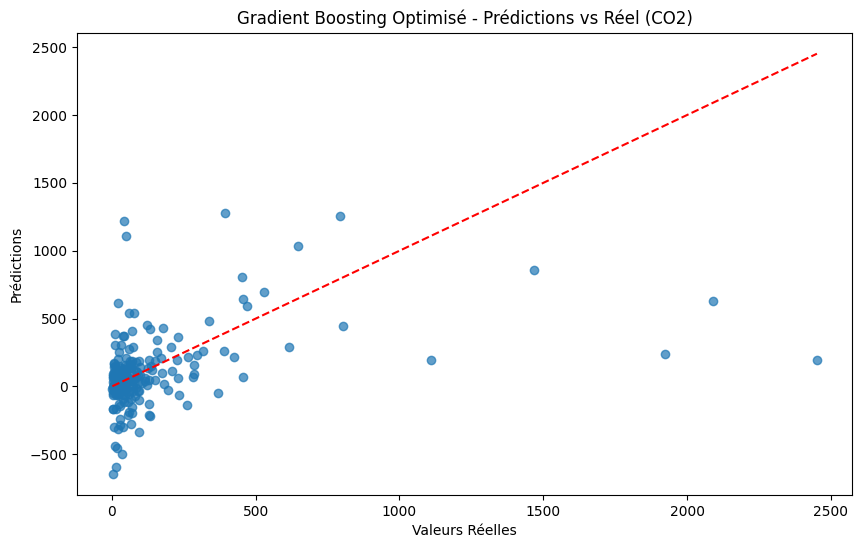

In [292]:
# Récupérer les meilleurs hyperparamètres
best_params = random_search.best_params_

# Extraire uniquement les paramètres du modèle (sans 'model__' utilisé dans le pipeline)
model_best_params = {key.split('__')[1]: value for key, value in best_params.items()}

# Créer une nouvelle instance du GradientBoostingRegressor avec les meilleurs hyperparamètres
best_model = GradientBoostingRegressor(random_state=42, **model_best_params)

# Créer un pipeline complet avec le modèle optimal
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('model', best_model)])

# Entraîner le pipeline sur l'ensemble des données d'entraînement
final_pipeline.fit(X_train, y_train_co2)

# Effectuer des prédictions sur les données de test
final_co2_pred = final_pipeline.predict(X_test)

# Calculer les métriques finales
final_mse = mean_squared_error(y_test_co2, final_co2_pred)
final_r2 = r2_score(y_test_co2, final_co2_pred)
final_mae = mean_absolute_error(y_test_co2, final_co2_pred)

# Afficher les performances finales
print("Performance du modèle optimisé sur les données de test :")
print(f"MSE : {final_mse}")
print(f"R2 : {final_r2}")
print(f"MAE : {final_mae}")

# Visualiser les prédictions finales vs les valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test_co2, final_co2_pred, alpha=0.7)
plt.plot([y_test_co2.min(), y_test_co2.max()], [y_test_co2.min(), y_test_co2.max()], color='red', linestyle='--')
plt.title('Gradient Boosting Optimisé - Prédictions vs Réel (CO2)')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.show()


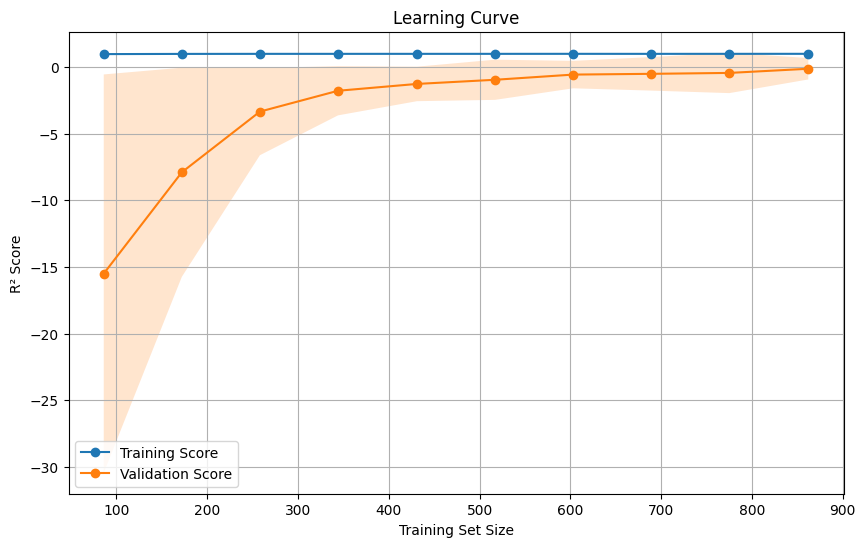

In [293]:

from sklearn.model_selection import learning_curve

# Prepare features and target
features = data.drop(columns=targets)
X = features.values
y = data[targets[0]].values  # Using TotalGHGEmissions as example target

# Initialize model
model = GradientBoostingRegressor(random_state=42, **model_best_params)

# Generate learning curve data
train_sizes, train_scores, valid_scores = learning_curve(model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.plot(train_sizes, valid_mean, label='Validation Score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2)
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend()
plt.grid()
plt.show()


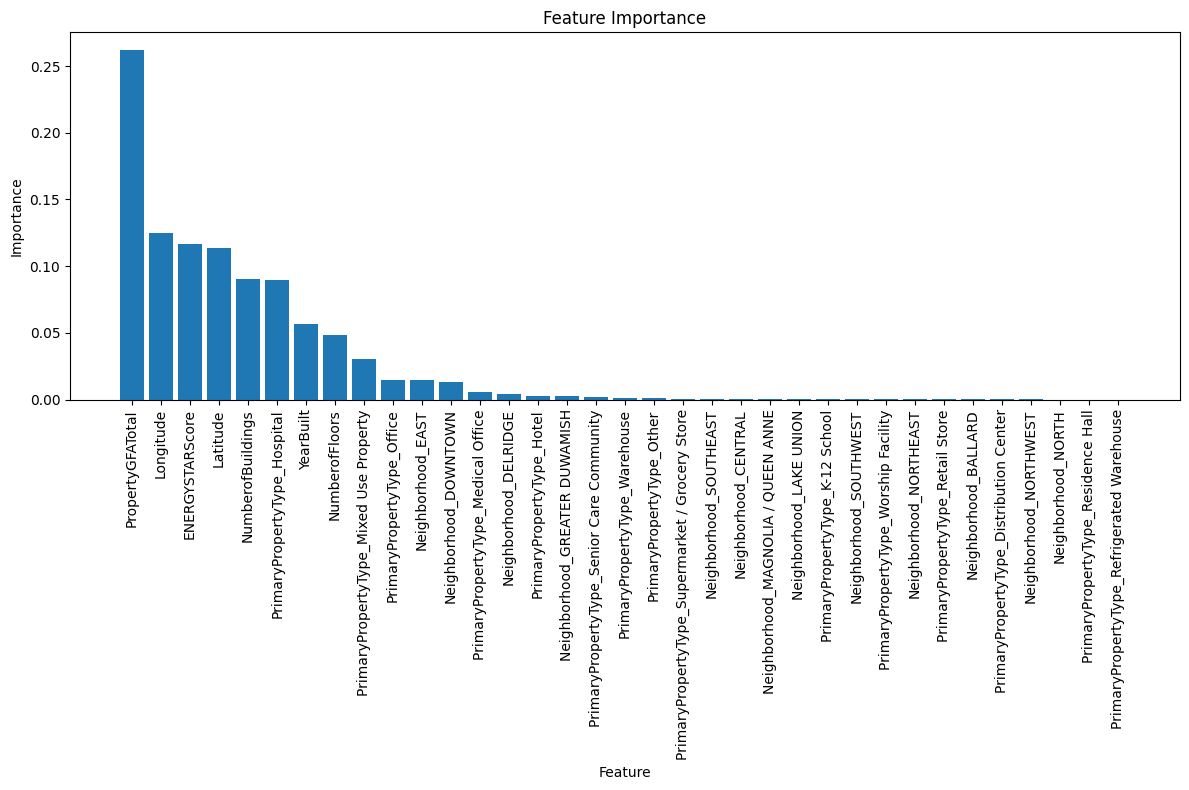

In [294]:

# Feature importance analysis 
model.fit(X, y)
importances = model.feature_importances_
feature_names = features.columns

# Plot feature importances
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [295]:
features = [col for col in data.columns if col not in targets]
features_no_es = [col for col in data.columns if col not in targets and col != 'ENERGYSTARScore']

In [296]:
# Prepare datasets with and without EnergyStarScore
X_with_energy_star = data[features]
X_without_energy_star = data[features_no_es]

# Initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42, **model_best_params)
gbr_no_es = GradientBoostingRegressor(random_state=42, **model_best_params)

# Train the models
gbr.fit(X_with_energy_star, y_co2)
gbr_no_es.fit(X_without_energy_star, y_co2)

# Predict
y_pred_with = gbr.predict(X_with_energy_star)
y_pred_without = gbr_no_es.predict(X_without_energy_star)

# Metrics
mae_with = mean_absolute_error(y_co2, y_pred_with)
mae_without = mean_absolute_error(y_co2, y_pred_without)
r2_with = r2_score(y_co2, y_pred_with)
r2_without = r2_score(y_co2, y_pred_without)

# Display results
print("Gradient Boosting Regressor Comparison:")
print("With EnergyStarScore - MAE: {:.4f}, R²: {:.4f}".format(mae_with, r2_with))
print("Without EnergyStarScore - MAE: {:.4f}, R²: {:.4f}".format(mae_without, r2_without))


Gradient Boosting Regressor Comparison:
With EnergyStarScore - MAE: 25.8326, R²: 0.9965
Without EnergyStarScore - MAE: 30.1405, R²: 0.9958


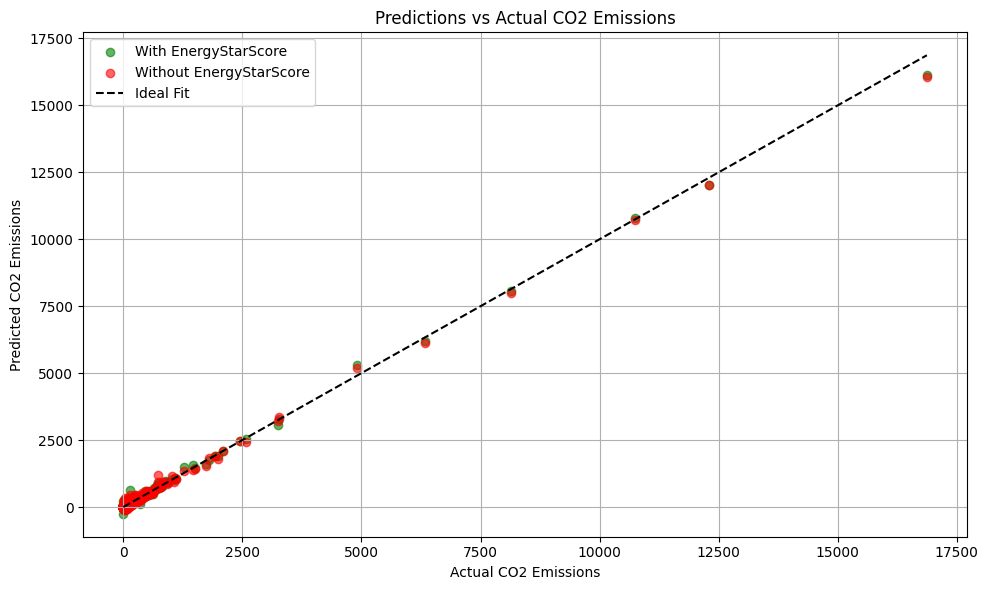

In [297]:
plt.figure(figsize=(10, 6))

# Predictions with EnergyStarScore
plt.scatter(y_co2, y_pred_with, alpha=0.6, color='green', label='With EnergyStarScore')
# Predictions without EnergyStarScore
plt.scatter(y_co2, y_pred_without, alpha=0.6, color='red', label='Without EnergyStarScore')

# Ideal fit line
plt.plot([y_co2.min(), y_co2.max()], [y_co2.min(), y_co2.max()], 'k--', label='Ideal Fit')
plt.title("Predictions vs Actual CO2 Emissions")
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()